Reconstrução de imagens
========================================



## Introdução



O experimento "Reconstrução de imagens" consiste em entender a implementação do código presente no capítulo 11 do livro Hands-On Genetic Algorithms with Python, do Eyal Wirsansky, que consiste na aplicação de um algorítmo genético para processamento de imagem, a fim de reconstruir um segmento dessa imagem, utilizando algumas bibliotecas conhecidas de processamento de imagem por Python (*Pillow*, *scikit-image* e *opencv-python*).  
Além da descrição dos passos utilizados pelo autor, o presente notebook conterá o código implementado, com imagens salvas no diretório **./images** e com parte do código retirada do GitHub do autor (https://github.com/PacktPublishing/Hands-On-Genetic-Algorithms-with-Python/tree/master/Chapter11).

## Objetivo



Esse algoritmo genético pretende reconstruir, utilizando poligonos, uma dada imagem, e comparar os resultados com a imagem original.  
Para isso, diversos processos tem que ser entendidos, como como ocorre o processamento de imagens pelas principais bibliotecas desse âmbito, como criar uma função objetivo capaz de encontrar a imagem mais semelhante à original, entre outros.  
O algoritmo também deve salvar algumas imagens durante o processo, no exemplo do livro, o melhor indivíduo de cada geração múltipla de 100.

## Importações



Todos os comandos de `import` devem estar dentro desta seção.



In [16]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy
import os

import image_test
import elitism_callback

import matplotlib.pyplot as plt
import seaborn as sns


import imageio

## Códigos e discussão



A abordagem utilizada será a criação de diversos poligonos semitransparentes que juntos, se sobrepondo, irão compor a imagem, o que torna possível uma visualização gráfica do processo de evolução. Para possibilitar o funcionamneto do algoritmo genético a biblioteca *deap* está sendo utilizada, juntamente com bibliotecas que possibilitarão a análise das imagens geradas.

In [2]:
POLYGON_SIZE = 5
NUM_OF_POLYGONS = 100

# calculate total number of params in chromosome:
# For each polygon we have:
# two coordinates per vertex, 3 color values, one alpha value
NUM_OF_PARAMS = NUM_OF_POLYGONS * (POLYGON_SIZE * 2 + 4)

# Genetic Algorithm constants:
POPULATION_SIZE = 200
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 10000
HALL_OF_FAME_SIZE = 25
CROWDING_FACTOR = 10.0  # crowding factor for crossover and mutation

# set the random seed:
RANDOM_SEED = 1000
random.seed(RANDOM_SEED)

As contantes comuns para algoritmos genéticos são definidas empiricamente pensando na melhor $\large \frac{\text{custo computacional}}{\text{eficiência do código}}$.

In [3]:
# create the image test class instance:
imageTest = image_test.ImageTest("images/euzinho.jpg", POLYGON_SIZE)

A istância da imagem é criada a partir de uma imagem dentro do diretório referido.

In [4]:
# calculate total number of params in chromosome:
# For each polygon we have:
# two coordinates per vertex, 3 color values, one alpha value
NUM_OF_PARAMS = NUM_OF_POLYGONS * (POLYGON_SIZE * 2 + 4)

Os parâmetros do cromossomo são definidos, levando em conta o número de poligonos, os valores de cor dentro do intervalo [0,255] e o valor de sua transparência (*alpha value*), também dentro do mesmo intervalo, além das coordenadas dos vértices dependendo da variável POLYGON_SIZE para cada polígono.  
No exemplo do livro, para o caso de um triângulo (com POLYGON_SIZE=3), teremos 10 parâmetros, $[x_{11}, y_{11}, x_{12}, y_{12}, x_{13}, y_{13}, r, g, b, alpha]$, por polígono.

In [5]:
# all parameter values are bound between 0 and 1, later to be expanded:
BOUNDS_LOW, BOUNDS_HIGH = 0.0, 1.0  # boundaries for all dimensions

Todos esses parâmetros são representados por *floats* entre 0 e 1.

Uma lista com NUM_OF_PARAMS valores entre 0 e 1 será gerada, e, para avaliar a solução, essa lista é separada em chunks representando cada polígono (cada chunk terá, portanto, (POLYGON_SIZE*2 + 4) valores).

In [6]:
toolbox = base.Toolbox()

Comecemos então o algoritmo propriamente dito, para isso iniciamos o *toolbox* da biblioteca deap.

In [7]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

Definimos uma função objetivo de minimização.

In [8]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

Criamos a classe de indivíduo.

In [9]:
# helper function for creating random real numbers uniformly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * NUM_OF_PARAMS, [up] * NUM_OF_PARAMS)]

Essa função foi criada para geral um *float* real aleatório entre 0 e 1 (LOW e UP definidos algumas células acima.)

In [10]:
# create an operator that randomly returns a float in the desired range:
toolbox.register("attrFloat", randomFloat, BOUNDS_LOW, BOUNDS_HIGH)

# create an operator that fills up an Individual instance:
toolbox.register("individualCreator",
                 tools.initIterate,
                 creator.Individual,
                 toolbox.attrFloat)

# create an operator that generates a list of individuals:
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)

Três operadores são criados, a fim de definir a população (seguindo então $\text{Geração dos genes} \to \text{Geração do indivíduo} \to \text{Geração da população}$).

In [11]:
# fitness calculation using MSE as difference metric:
def getDiff(individual):
    return imageTest.getDifference(individual, "MSE"),
    #return imageTest.getDifference(individual, "SSIM"),

Como comentado mais acima, precisariamos pensar em como a função objetivo funcionaria, nesse caso usa-se um método para calcular o MSE da imagem gerada em comparação com a original. A programação do método envolve a biblioteca de processamento de imagens **OpenCV** ou **SkImage**.

In [12]:
toolbox.register("evaluate", getDiff)

In [13]:
# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)

toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)

Os indivíduos devem ser avaliados, cruzados e mutados, e essas informações devem ser passadas para a *toolbox* da **deap**, é isso que as células acima fazem.

In [14]:
# save the best current drawing every 100 generations (used as a callback):
def saveImage(gen, polygonData):

    # only every 100 generations:
    if gen % 100 == 0:

        # create folder if does not exist:
        folder = "images/results/run-{}-{}".format(POLYGON_SIZE, NUM_OF_POLYGONS)
        if not os.path.exists(folder):
            os.makedirs(folder)

        # save the image in the folder:
        imageTest.saveImage(polygonData,
                            "{}/after-{}-gen.png".format(folder, gen),
                            "After {} Generations".format(gen))

Com um número muito grande de gerações, o número de imagens gerado também é muito grande, para isso, o autor criou a função **saveImage()** com a restrição de salvar imagens apenas de gerações múltiplas de 100 (uma ótima decisão, talvez eu faria um código para salvar apenas **n** imagens de uma rodada do algorítmo, o que poderia ser melhor para analisar rodadas com altos **MAX_GENERATIONS**).

gen	nevals	min    	avg    
0  	200   	15842.8	25929.1
1  	166   	15842.8	23744.3
2  	171   	15842.8	22643.4
3  	170   	15842.8	21474.6
4  	163   	15261  	20619.1
5  	165   	14608.2	20036.6
6  	172   	14608.2	19672.4
7  	165   	14505.9	19120  
8  	162   	14116.8	18401.2
9  	164   	13548.3	18205.9
10 	165   	13548.3	17856.8
11 	160   	13548.3	17673.5
12 	170   	13548.3	17297.7
13 	161   	12886.8	16873.7
14 	170   	11534.5	16702.7
15 	168   	11534.5	16542  
16 	166   	11534.5	16557.4
17 	167   	11534.5	16076.3
18 	166   	11534.5	15666.2
19 	167   	11534.5	15469.7
20 	165   	11534.5	14957.8
21 	162   	11534.5	14833.1
22 	167   	10602.6	14306.5
23 	165   	10183.4	13792  
24 	164   	10183.4	12926.6
25 	162   	10183.4	12439.5
26 	165   	9982.27	12026.5
27 	164   	9548.91	11598  
28 	164   	9548.91	11191.8
29 	171   	9548.91	11026  
30 	171   	9298.88	10909  
31 	172   	9159.45	10643.8
32 	166   	8932.79	10419  
33 	163   	8733.92	10218.5
34 	169   	8733.92	9967.61
35 	157   	8733.92	9870.28
3

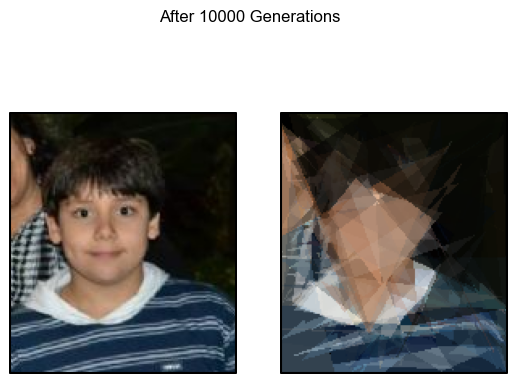

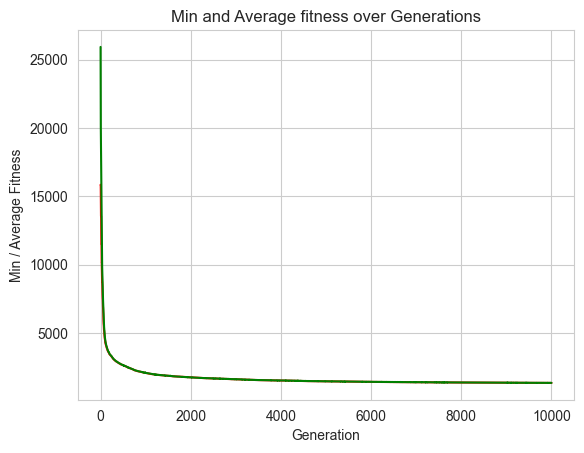

In [15]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


    # perform the Genetic Algorithm flow with elitism and 'saveImage' callback:
    population, logbook = elitism_callback.eaSimpleWithElitismAndCallback(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      callback=saveImage,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)

    # print best solution found:
    best = hof.items[0]
    print()
    print("Best Solution = ", best)
    print("Best Score = ", best.fitness.values[0])
    print()

    # draw best image next to reference image:
    imageTest.plotImages(imageTest.polygonDataToImage(best))

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.figure("Stats:")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # show both plots:
    plt.show()

if __name__ == "__main__":
    main()

Finalmente o algoritmo genético pode rodar e encontrar uma imagem que se assemelhe à imagem original criada com poligonos semi-transparentes.  
Nesse caso o *hall of fame* algorítmo usa a estratégia de passar todos os selecionados intactos para a próxima geração, a **estratégia elitista**.  
Como apresentado no objetivo do algoritmo, imagens devem ser salvas no processo, para isso foi criada a classe **eaSimpleWithElitismAndCallback()**, no arquivo importado **elitism_callback.py**, cujo método será ativado a cada 100 gerações.

### Criando um GIF

In [18]:
# Diretório onde as imagens serão salvas
diretorio = "./images/results/run-5-100/"

# Nome base das imagens
nome_base = 'after-{}-gen.png'

# Lista para armazenar os nomes dos arquivos das imagens
nomes_imagens = [nome_base.format(num) for num in range(100, 10000 + 1, 100)]

# Cria a animação a partir das imagens
imagens = []
for nome_imagem in nomes_imagens:
    caminho_imagem = diretorio + nome_imagem
    imagens.append(imageio.imread(caminho_imagem))

# Nome do arquivo de saída
arquivo_saida = diretorio + 'animacao.gif'

# Salva a animação como um arquivo gif
imageio.mimsave(arquivo_saida, imagens, duration=0.5)

C:\Users\pedro220045\AppData\Local\Temp\ipykernel_28724\1959066754.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imagens.append(imageio.imread(caminho_imagem))


## Conclusão



O algoritmo utiliza muitos dos conceitos apresentados em aula juntamente com as mais famosas bibliotecas de processamento de imagem do Python.  
O autor cria, de forma muito inteligente, estratégias para o funcionamento do programa, como o retorno de apenas informações simples num primeiro momento, mostrando apenas a melhor imagem ao final de todas as gerações, porém salvando todas as imagens anteriores em uma pasta.  
Esse algoritmo torna visível o processo de evolução, para melhor visualização, criei um gif (em **./images/results**) ilustrando o processo com todas as imagens geradas em dois casos:
- Com 10000 gerações e passo de 100 gerações entre as imagens;
- Com 1000 gerações e passo de 1 geração entre as imagens.
Com isso podemos perceber a eficiência do código no quesito evolução, percebendo mutações (que possuem chance relativamente alta - 50% - de ocorrer, a fim de criar uma variação maior na distribuição dos polígonos).  
  
Parâmetros do código podem ser variados para gerar uma imagem mais similar, como:
- Número de polígonos;
- Número de vértices dos polígonos;
- Tamanho da população e número de gerações (obviamente, da mesma forma que ocorre com nossos outros experimentos em algorítmos genéticos);
- Cores da imagem de referência (como o programa usa sobreposição de poligonos semitransparentes, uma imagem com menos componentes em canais diferentes, com um exemplo de uma imagem em escala de verde, sem componentes nos canais R e B, é mais fácil de ser aproximada).

Algo interessante que podemos pensar é que, com um número suficiente de polígonos, eventualmente eles se reduziriam ao tamanho de um pixel para compror a imagem com 0 de MSE. Para calcular o número de polígonos necessários para isso basta multiplicar a altura em pixels pela sua largura também em pixels.  
Também por esse motivo percebemos uma diminuição na mudança do fitness com o passar das gerações, já que, com um número limitado de polígonos, existirá uma imagem que mais se assemelha à imagem referência.

## Referências consultadas



1.  EYAL WIRSANSKY. Hands-On Genetic Algorithms with Python: Applying genetic algorithms to solve real-world deep learning and artificial intelligence problems, 2020.

## Playground



Todo código de teste que não faz parte do seu experimento deve vir aqui. Este código não será considerado na avaliação.

